## Loading defaults from sqllite

In [8]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('sqlite:///question.db')
all_prompts = pd.read_sql('prompt', engine)
all_contexts = pd.read_sql('context', engine)
all_tags = pd.read_sql('tag', engine)
answer_context = all_contexts.loc[all_contexts['type'] == 'style', 'context'].get(1)
system_context = all_contexts.loc[all_contexts['type'] == 'personal', 'context'].get(0)
context = system_context + "\r\n" + answer_context
print(context)

I am a citizen of Austria, and my tax residency is in Armenia. I need a portfolio that minimizes my expenses related my tax obligations. 
I aim for high returns. I am open to take risks, but I do not like gambling.
Please be as concise as possible. If I have a bad idea that can be a problem, be as direct as possible. Don't hold back. 


In [9]:
def get_prompt_by_id(id: str) -> str:
    try:
        return all_prompts[all_prompts["id"] == id]["prompt"].iloc[0]
    except:
        return "No prompt found with that ID"

def get_prompts_per_category(tag: str):
    all_prompt_tags = all_tags.loc[
        all_tags['tag_name'] == tag,
        'prompt_id'].tolist()
    return all_prompts[all_prompts['id'].isin(all_prompt_tags)]

# Load keys and tokens

In [14]:
import os
import requests
from dotenv import load_dotenv

load_dotenv()

NOTION_TOKEN = os.getenv("doc.notion.api")
DATABASE_ID = os.getenv("doc.notion.db")

headers = {
    "Authorization": "Bearer " + NOTION_TOKEN,
    "Content-Type": "application/json",
    "Notion-Version": "2022-06-28",
}
OPEN_AI_DEFAULT_MODEL = "gpt-4.1"
GEMINI_DEFAULT_MODEL = 'gemini-2.0-flash'
GENERAL_RESEARCH_CONTEXT = "I believe that the current market is difficult due to geopolitical changes, high debts and tariff uncertainty."
TEMPERATURE = 1

# Calling LLMs

In [15]:
from enum import Enum

class LLM(Enum):
    OPENAI = 1
    GEMINI = 2

def get_answer(stock_ticker: str, question_text: str, LLM = LLM.OPENAI) -> str:
    company_reference = ""
    if stock_ticker:
        company_reference = f"I am exploring the company with the stock ticker: {stock_ticker}."
    if GENERAL_RESEARCH_CONTEXT:
        company_reference = company_reference + "\r\n\r\n" + GENERAL_RESEARCH_CONTEXT
    question = company_reference + "\r\n\r\n" +  question_text  + "\r\n\r\n"
    match LLM:
        case LLM.OPENAI:
            get_answer_openAI(question)
        case LLM.GEMINI:
            question = context + question
            get_answer_gemini(question)
        case _:
            default_llm(question) # take openai as default
    return get_answer_openAI(question)

def get_answer_openAI(question: str, model = OPEN_AI_DEFAULT_MODEL, temperature = TEMPERATURE) -> str:
    from openai import OpenAI
    OPENAI_KEY = os.getenv("ai.openai.pwd")
    client = OpenAI(
      api_key=OPENAI_KEY
    )

    completion = client.chat.completions.create(
      model=model,
      messages=[
        {"role": "system", "content": context},
        {"role": "user", "content": question}

      ],
      temperature = temperature
    )
    return completion.choices[0].message.content

def get_answer_gemini(question: str, model = GEMINI_DEFAULT_MODEL, temperature = TEMPERATURE) -> str:
    GOOGLE_API_KEY = os.getenv("ai.gemini.key")
    from google import genai
    from google.genai import types
    client = genai.Client(api_key=GOOGLE_API_KEY)
    response = client.models.generate_content(
        model=model,
        contents=question,
        config=types.GenerateContentConfig(
            temperature=temperature,
        ),
    )
    return response.text

default_llm = get_answer_openAI

## Notion Helper Functions

In [18]:
from datetime import datetime
def ask_question(stock_ticker: str, question_id: str,
                 question_text = None, llm = LLM.OPENAI) -> None:
    date_str = datetime.now().strftime("%Y_%m_%d")
    if stock_ticker:
        properties = get_title_property(
            f"{stock_ticker}-"
            f"{date_str}-{question_id}-{llm}")
    else:
        properties = get_title_property(
            f"generic-{date_str}-{question_id}-{llm}")
    page_block_id = create_page(properties)

    if question_text is None:
        question_text = get_prompt_by_id(question_id)
    if len(question_text) > 0:
        write_chunked(page_block_id, question_text)
        write_chunked(page_block_id,
                      get_answer(stock_ticker,
                                 question_text,
                                 llm))

def get_title_property(title: str):
    return {'Name': {'id': 'title',
  'type': 'title',
  'title': [{'type': 'text',
    'text': {'content': title, 'link': None},
    'annotations': {'bold': False,
     'italic': False,
     'strikethrough': False,
     'underline': False,
     'code': False,
     'color': 'default'},
    'plain_text': title,
    'href': None}]}}

def create_page(title_properties: dict) -> str:
    create_url = "https://api.notion.com/v1/pages"
    payload = {"parent": {"database_id": DATABASE_ID},
               "properties": title_properties}
    res = requests.post(create_url, headers=headers, json=payload)
    if res.status_code == 200:
        print(f"{res.status_code}: Page created successfully")
    else:
        print(f"{res.status_code}: Error during page creation")
    return res.json()["id"]

def write_chunked(page_block_id, text, chunk_size = 2000):
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        if not write_to_page(page_block_id, create_block(chunk)):
            break

def write_to_page(page_block_id: str, data: dict) -> bool:
    edit_url = f"https://api.notion.com/v1/blocks/{page_block_id}/children"
    res = requests.patch(edit_url, headers=headers, json=data)
    if res.status_code != 200:
        print(f"{res.status_code}: Error during page editing")
        return False
    return True

def create_block(content : str) -> dict:
    return {
        "children": [
            {
                "object": "block",
                "type": "paragraph",
                "paragraph": {
                    "rich_text": [
                        {
                            "type": "text",
                            "text": {
                                "content": content,
                            },
                        }
                    ]
                },
            },
        ]
    }

# Research

In [20]:
# show all questions to a topic
get_prompts_per_category("earning")

,id,domain,prompt
4,earning_base,qualitative,An earning call of the company is ahead. What ...


In [19]:
 get_prompt_by_id("earning_base")

'An earning call of the company is ahead. What shall I check to make a decision to sell my position or buy more?'

In [28]:
stock_ticker = None
text = "Assuming there will be peace between Ukraine and Russia. Give me three companies on the stock market that benefit from it and three that do not."
ask_question(stock_ticker, "Shorting_Opportunities", text, LLM.OPENAI)

200: Page created successfully


# RAGs

In [ ]:
# langchain basics (9.4)

In [21]:
investment_persona = """“I have a computer science background. I have been working for many different companies on digital transformation projects. I understand well how AI can change companies' businesses. I am looking for stocks of companies that might get transformed through AI but have not yet been overrun by investors.

I want to be financially independent in five years. I have approximately 500,000 USD available for investment. I want to be able to calculate the money I make passively with an average yield of assets (interests, staking rewards, dividends).

I mainly hold stocks and ETFs. I also hold bonds and crypto. I want to keep some amount in index funds.

I am interested in the future of autonomous driving and the monetization of climate change mitigation. I also believe in the increase in demand of reliable, non-volatile energy sources, such as nuclear energy due to the increasing demand of nuclear energy. I am also open to alternatives to nuclear energy.

I use Interactive Broker and Alpaca as brokers. I use cold wallets to store cryptocurrency.

I can take risks if decisions have been thoroughly researched. If the valuation of the asset is temporarily lower, I do not have a problem as long as I see a long-term potential. I am okay with shorting some positions but I prefer long-term quality investing. I do not do day trading.

I want to diversify. Diversification also includes assets worldwide, as I see political risks in the US. Otherwise, I am fine with holding most assets in the US market.

I am a US-American citizen. My tax residency is in the UK. I want to minimize the taxes we have to pay.

I do not like to invest in the tobacco industry and companies that ignore animal rights.
"""

In [24]:
from langchain_openai import ChatOpenAI
OPENAI_KEY = os.getenv("ai.openai.pwd")
llm = ChatOpenAI(

    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=OPENAI_KEY)
messages = [
    (
        "system",
        investment_persona,
    ),
    ("human", "Provide a SWOT analysis of Google."),
]
ai_msg = llm.invoke(messages) #A
ai_msg


AIMessage(content="Certainly! Here's a SWOT analysis of Google:\n\n**Strengths:**\n\n1. **Market Leadership:** Google is a dominant player in the search engine market, with a significant market share globally. Its brand is synonymous with search.\n\n2. **Diverse Product Portfolio:** Beyond search, Google has a wide range of products and services, including Android, YouTube, Google Cloud, and Google Ads, which contribute to its revenue streams.\n\n3. **Innovation and R&D:** Google is known for its innovation and investment in research and development, leading to cutting-edge technologies in AI, machine learning, and quantum computing.\n\n4. **Strong Financial Performance:** Google has a robust financial position with substantial revenue and profit margins, providing resources for further investment and expansion.\n\n5. **Data and Analytics:** With access to vast amounts of data, Google can leverage analytics to improve its services and target advertising effectively.\n\n**Weaknesses:**\

# Listing 9.5

In [25]:
from langchain.agents import AgentType, initialize_agent
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

tools = [YahooFinanceNewsTool()]
agent_chain = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
)
agent_chain.invoke(
    "What happened today with Microsoft stocks?", #A
)


USER_AGENT environment variable not set, consider setting it to identify your requests.
/var/folders/6g/gq4hv4r53q35rzvjssls_3h00000gn/T/ipykernel_13720/730142885.py:5: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent_chain = initialize_agent(




> Entering new AgentExecutor chain...
To answer this question, I need to find the latest financial news about Microsoft. 
Action: yahoo_finance_news
Action Input: MSFT
Observation: OpenAI looks to ship 100M AI ‘companion’ devices for everyday life, WSJ reports
Sam Altman told his staff that Microsoft (MSFT)-backed OpenAI aims to ship 100M AI “companion” devices meant for everyday life, and to release the first by late 2026, The Wall Street Journal’s Berber Jin reports. The AI device, not a phone or glasses, will be pocket-size, screen-free and contextually aware, Jin writes. Sam Altman and Jony Ive envision a “family of devices” integrating hardware and software, according to the report. Published first on TheFly – the ultimate source for real-time, m

FTC drops case over Microsoft’s $69B deal for Activision, Reuters reports
The FTC has dropped a case that sought to block Microsoft’s (MSFT) $69B purchase of Activision Blizzard, saying that pursuing the case was not in the public inte

{'input': 'What happened today with Microsoft stocks?',
 'output': "Microsoft has several positive developments: OpenAI plans to ship 100M AI devices, the FTC dropped its case against Microsoft's Activision deal, and analysts are bullish on Microsoft's AI advancements."}

# AI Agents

In [30]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv("ai.openai.pwd")

In [31]:
from langchain_core.documents.base import Document

all_docs = []
files = ["pony.txt", "oust.txt", "lazr.txt", "invz.txt", "aeva.txt"]
for f in files:
    file = open(f, "r")
    content = file.read()
    doc = Document(content)
    all_docs.append(doc)
    file.close()

In [32]:
generic = """I have a computer science background. I have been working for many different companies on digital transformation projects. I understand well how AI can change companies' businesses. I am looking for stocks of companies that might get transformed through AI but have not yet been overrun by investors."""

pro_lidar_text = """I believe in the future of autonomous driving. I believe that autonomous driving needs LIDAR system. Do not recommend me any companies that reject LIDAR."""
con_lidar_context = """Please prefer companies that focus on solutions without LIDAR systems as they are expensive."""
all_docs.append(Document(generic + pro_lidar_text))

In [33]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True,
)
all_splits = text_splitter.split_documents(all_docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 268 sub-documents.


In [34]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)
document_ids = vector_store.add_documents(documents=all_splits)

In [35]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [36]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-4.1", model_provider="openai")
question = "Recommend companies in the autonomous driving sector with good recent earnings."

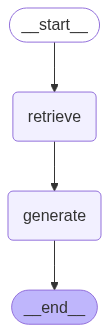

In [37]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

graph_builder = (StateGraph(State).add_sequence
                 ([retrieve, generate]))
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
result = graph.invoke({"question": question})

print(f'Answer: {result["answer"]}')

Answer: Based on the context, Innoviz is a strong recommendation in the autonomous driving sector—they have good recent earnings, strong partnerships (such as with Mobileye and NVIDIA), a robust pipeline with OEMs globally, and market-leading LIDAR technology. They are also expanding production and have prudent financial management. Innoviz emphasizes LIDAR and is well-positioned for growth in both automotive and adjacent sectors.
